In [1]:
from IPython.display import HTML
style = '''<style>
    li {
        text-align: justify;
    }
</style>'''
HTML(style)

In [2]:
%load_ext autoreload
%load_ext watermark
%autoreload 2

# 1. Imports and Project Environment
* I have turned this Notebook file into a multipurpose project report because combining the Markdown and Python output was very convenient.
* Some functions that I have written are inside the `/project/util.py` file to reduce visual clutter.

In [3]:
from project.util import *

In [4]:
%watermark -v -p sklearn,pandas,numpy,matplotlib,seaborn

Python implementation: CPython
Python version       : 3.13.7
IPython version      : 9.6.0

sklearn   : 1.7.2
pandas    : 2.3.3
numpy     : 2.3.4
matplotlib: 3.10.7
seaborn   : 0.13.2



# 2. Data Preparation
* Reading the raw data in CSV format and renaming the columns
* Extracting labels (Diagnosis) from the features and mapping classes as "Malignant -> 1" and "Benign -> 0"
* Normalizing features using MinMaxScaler

In [5]:
# Column names taken from the "Variables Table" part of the dataset source
col_names = ['ID', 'Diagnosis',
             'radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1', 'compactness1',
             'concavity1', 'concave_points1', 'symmetry1', 'fractal_dimension1',
             'radius2', 'texture2', 'perimeter2', 'area2', 'smoothness2', 'compactness2',
             'concavity2', 'concave_points2', 'symmetry2', 'fractal_dimension2',
             'radius3', 'texture3', 'perimeter3', 'area3', 'smoothness3', 'compactness3',
             'concavity3', 'concave_points3', 'symmetry3', 'fractal_dimension3']

data_df = pd.read_csv('data/wdbc.data', sep=',', names=col_names)
display_pruned_df(data_df)

,ID,Diagnosis,radius1,texture1,...,concave_points3,symmetry3,fractal_dimension3
0,842302,M,17.99,10.38,...,0.2654,0.4601,0.1189
1,842517,M,20.57,17.77,...,0.186,0.275,0.08902
...,...,...,...,...,...,...,...,...
567,927241,M,20.6,29.33,...,0.265,0.4087,0.124
568,92751,B,7.76,24.54,...,0.0,0.2871,0.07039


In [6]:
features = data_df.drop(['ID'], axis=1)
labels = features.pop('Diagnosis').map({'B': 0, 'M': 1})

In [7]:
scaler = MinMaxScaler()
features = pd.DataFrame(scaler.fit_transform(features), columns=col_names[2:])
display_pruned_df(features)

,radius1,texture1,perimeter1,area1,...,concave_points3,symmetry3,fractal_dimension3
0,0.521037,0.022658,0.545989,0.363733,...,0.912027,0.598462,0.418864
1,0.643144,0.272574,0.615783,0.501591,...,0.639175,0.23359,0.222878
...,...,...,...,...,...,...,...,...
567,0.644564,0.66351,0.665538,0.475716,...,0.910653,0.497142,0.452315
568,0.036869,0.501522,0.02854,0.015907,...,0.0,0.257441,0.100682


# 3. Distribution of Features

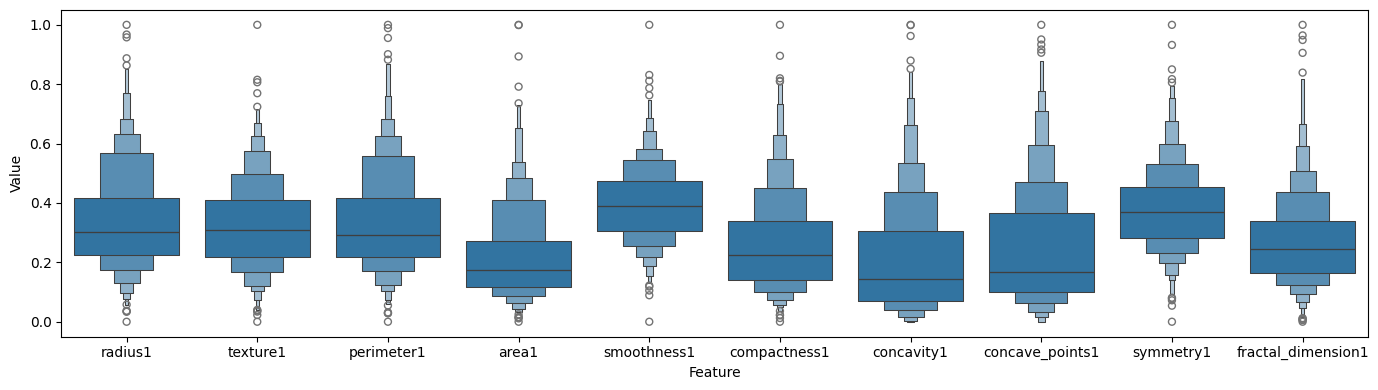

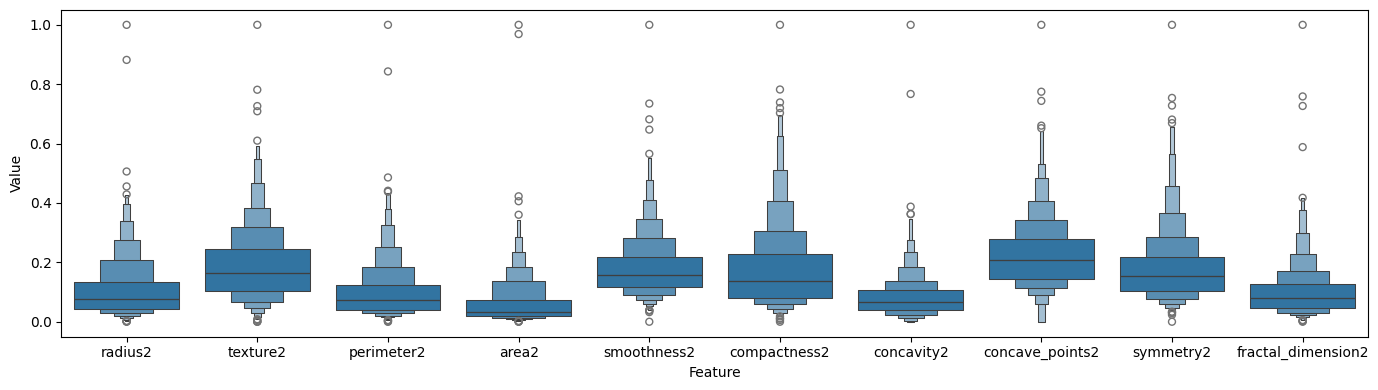

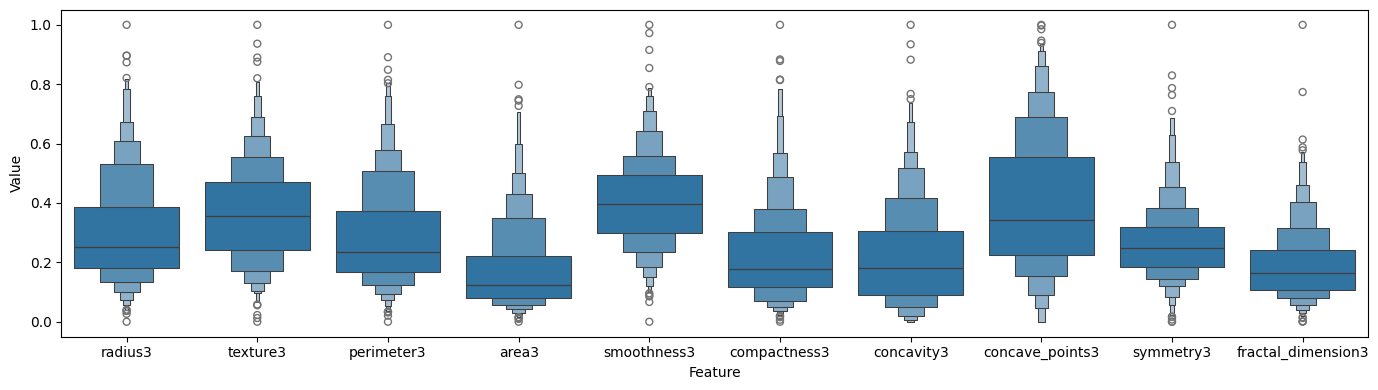

In [8]:
for i in range(3):
    f, ax = plt.subplots(figsize=(14, 4))
    subset = features.iloc[:, i*10:(i+1)*10].melt(var_name='Feature', value_name='Value')
    sns.boxenplot(data=subset, x='Feature', y='Value', ax=ax)
    plt.tight_layout()
    plt.show()

# 4. Determining the Number of Clusters
* The elbow point can be selected as `k=2`, since the change in inertia becomes less significant after that point.
* While determining the number of clusters, higher silhouette score is desired. So, `k=2` is once again the best choice.
* Therefore, we can safely assume that the number of clusters is 2.

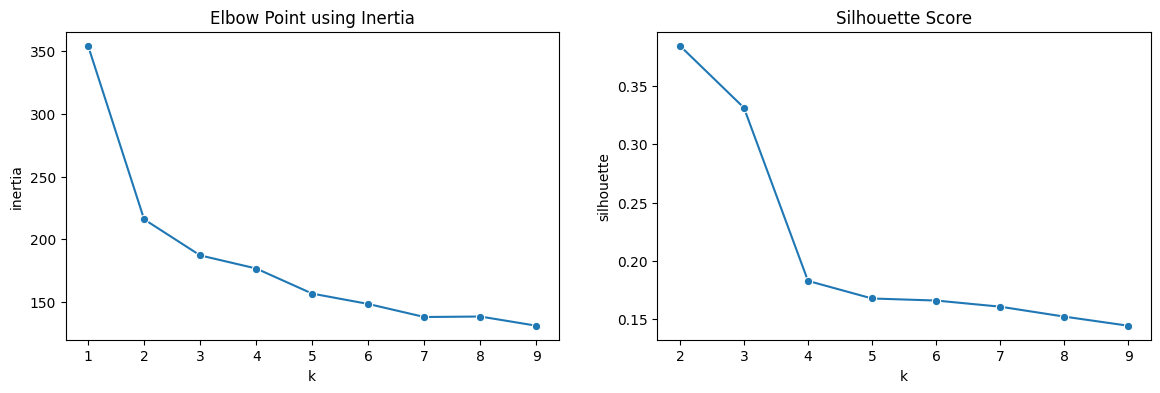

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

plot_elbow_method_with_k(ax1, features, k_start=1, k_end=9)
plot_silhouette_score_with_k(ax2, features, k_start=2, k_end=9)

# 5. Clustering and Evaluation

## 5.1. K-Means
* `k=2` was found as the number of clusters in the previous section, so we use it here as the parameter <b>n_clusters=2</b>.
* Using Adjusted Rand Index (ARI) as the evaluation metric (which ranges between 0 and 1) gives a decent result.

In [10]:
k_means = KMeans(n_clusters=2, random_state=0).fit(features)
k_means_ari_score = adjusted_rand_score(labels, k_means.labels_)
print(f'+ K-Means ARI Score: {k_means_ari_score:.6f}')

+ K-Means ARI Score: 0.730175


## 5.2. DBSCAN

* First, I have used the range `2 <= minPts <= 11` to find the optimal eps ranges using 10th and 95th percentile distances of Nearest Neighbor pairs.
* When evaluated with the Silhouette Score metric, the scores for `minPts=[2,3]` seems ill-behaved even after the potential knee-point. Therefore, I have decided to use `minPts=4` going forward.
* Furthermore, evaluating the DBSCAN labels against the ground truth using ARI metric yields a significantly worse score compared to the K-Means algorithm.


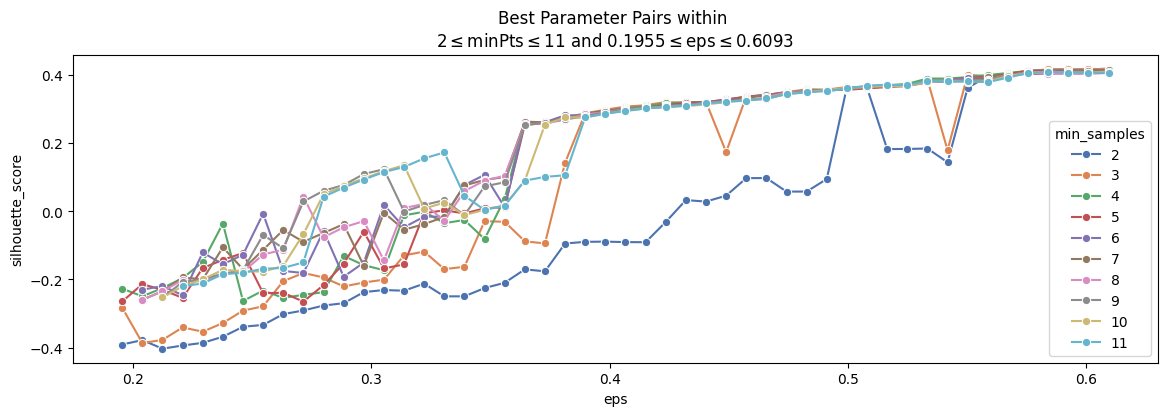

In [11]:
dbscan_params_df = find_optimal_dbscan_params(features, min_samples_range=(2, 11))

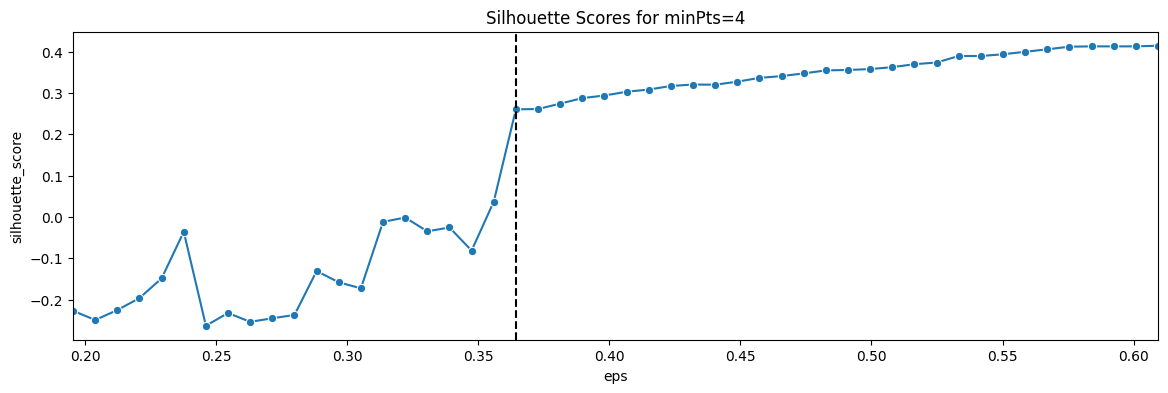

In [12]:
min_samples = 4
eps = find_optimal_eps(dbscan_params_df, min_samples=min_samples, min_eps=0.34)

In [13]:
dbscan = DBSCAN(min_samples=min_samples, eps=eps)
dbscan_labels = dbscan.fit_predict(features)
dbscan_ari_score = adjusted_rand_score(labels, dbscan_labels)
print(f'+ DBSCAN ARI Score: {dbscan_ari_score:.4f}')

+ DBSCAN ARI Score: 0.2115


# 6. Visualisation on 2D Space
* To visualise the clusters on 2D, I have used PCA to get the two best components that represent the 30-dimensional space.

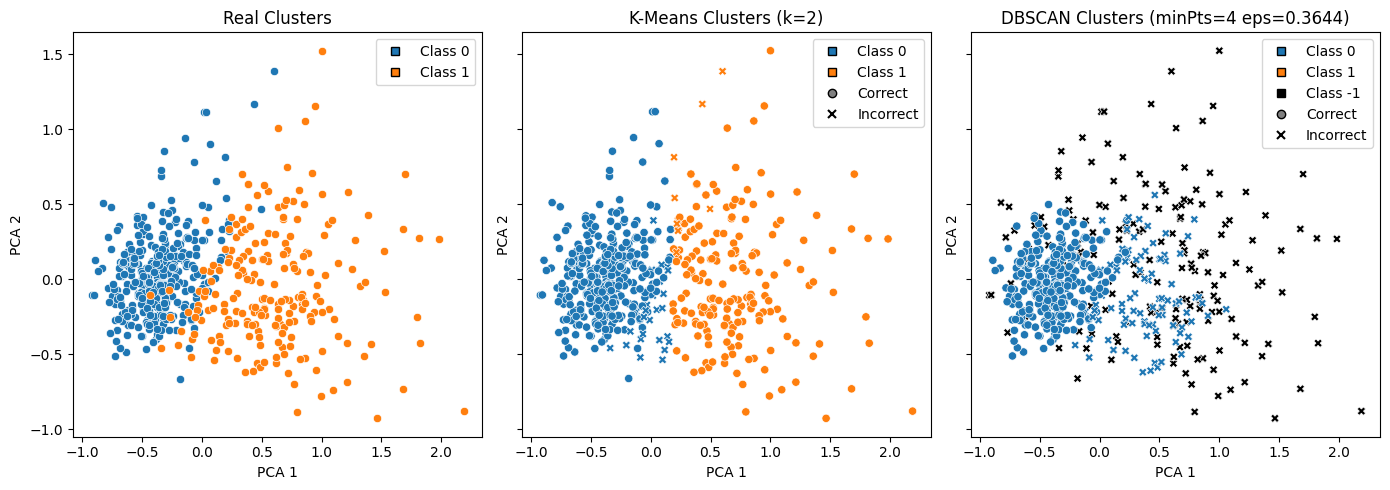

In [14]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(14, 5))

plot_on_pca(ax1, features, labels, title='Real Clusters')
plot_on_pca(ax2, features, labels, k_means.labels_, title='K-Means Clusters (k=2)')
plot_on_pca(ax3, features, labels, dbscan_labels, title=f'DBSCAN Clusters (minPts={min_samples} eps={eps:.4f})')
plt.tight_layout()

## Ege Altıok - 2025900151